[EMアルゴリズム徹底解説 \- Qiita](https://qiita.com/kenmatsu4/items/59ea3e5dfa3d4c161efb)

[Qiita\_Contents/Gaussian\_mixture\_demo\-automate\-animate\.ipynb at master · matsuken92/Qiita\_Contents](https://github.com/matsuken92/Qiita_Contents/blob/master/EM_Algorithm/Gaussian_mixture_demo-automate-animate.ipynb)

In [1]:
import numpy
import scipy
import scipy.stats
import matplotlib.pyplot as plt
plt.rcParams["patch.force_edgecolor"] = True
import seaborn
seaborn.set_style("whitegrid", {'grid.linestyle': '--'})

## create data

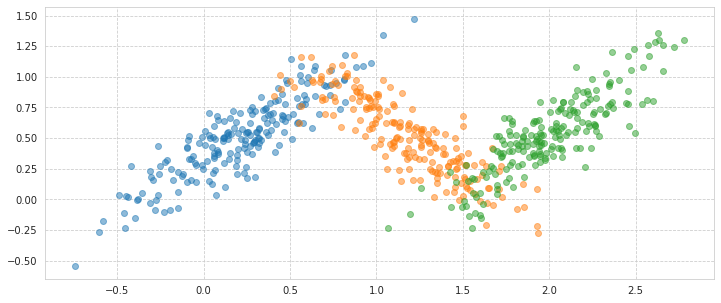

In [2]:
mu_true = numpy.array(
    [
        [0.2, 0.5],
        [1.2, 0.5],
        [2.0, 0.5],
    ]
)
sigma_true = numpy.array(
    [
        [[0.1, 0.085], [0.085, 0.1],],
        [[0.1, -0.085], [-0.085, 0.1],],
        [[0.1, 0.085], [0.085, 0.1],],
    ]
)

org_data = [
    scipy.stats.multivariate_normal.rvs(mean=mu, cov=sigma, size=200) for mu, sigma in zip(mu_true, sigma_true)
]

plt.figure(figsize=(12, 5))
for d in org_data:
    plt.scatter(x=d[:, 0], y=d[:, 1], alpha=0.5)

# Initialize

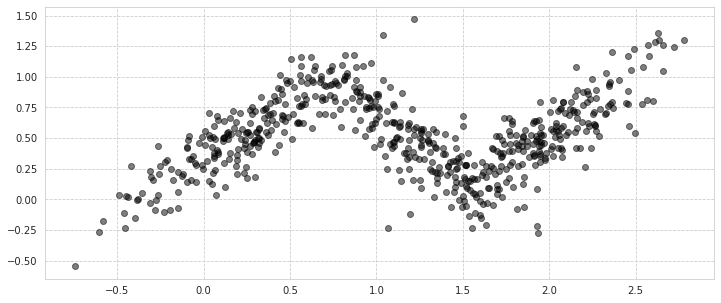

In [3]:
data = numpy.concatenate(org_data)

plt.figure(figsize=(12, 5))
plt.scatter(x=data[:, 0], y=data[:, 1], alpha=0.5, c='black')

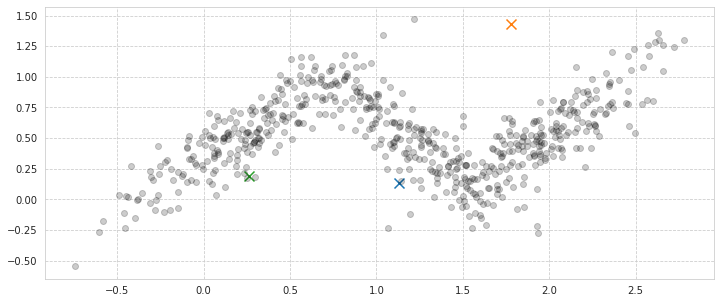

In [4]:
NUMBER_OF_CLUSTERS = 3

mu = numpy.random.uniform(low=data.min(axis=0), high=data.max(axis=0), size=(NUMBER_OF_CLUSTERS, data.shape[1]))

sigma = numpy.array([
    [[0.1, 0], [0, 0.1]],
    [[0.1, 0], [0, 0.1]],
    [[0.1, 0], [0, 0.1]],
])

plt.figure(figsize=(12, 5))
for m in mu:
    plt.scatter(x=m[0], y=m[1], marker='x', s=100)
plt.scatter(x=data[:, 0], y=data[:, 1], alpha=0.2, c='black')

# EM algorithm
- $n$: number of data
- $k$: number of clusters
- $z_{nk}$: latent variable where the datum belongs
- $\gamma(z_{nk})$: responsibility
- 
## E-step


In [5]:
import numpy.typing
import dataclasses

from logging import getLogger, StreamHandler, DEBUG, INFO,Logger
logger = getLogger(__name__)
handler = StreamHandler()
handler.setLevel(INFO)
logger.setLevel(DEBUG)
logger.addHandler(handler)
logger.propagate = False

@dataclasses.dataclass
class EM_Algorithm:
    NUMBER_OF_CLUSTERS: int
    mu: numpy.typing.ArrayLike
    sigma: numpy.typing.ArrayLike
    logger: Logger = logger

    def __post_init__(self):
        assert self.NUMBER_OF_CLUSTERS is not None

        assert self.mu.shape[0] == self.NUMBER_OF_CLUSTERS

        assert self.sigma.shape[0] == self.NUMBER_OF_CLUSTERS
        assert self.sigma.shape[1:] == (self.mu.shape[1], self.mu.shape[1])

        self.pi = numpy.ones(self.NUMBER_OF_CLUSTERS)/self.NUMBER_OF_CLUSTERS
        

    def likelihood(self, data):
        """return likelihood as a (N_of_Clusters, data_length)-shape array
        """
        return numpy.stack(
            [p * scipy.stats.multivariate_normal.pdf(data, m, s) for p, m, s in zip(self.pi, self.mu, self.sigma)]
        )

    def e_step(self, data):
        e_likelihood = self.likelihood(data)
        self.logger.debug('e_likelihood.shape: {}'.format(e_likelihood.shape))

        self.gamma = e_likelihood / e_likelihood.sum(axis=1, keepdims=True)
        self.logger.debug('gamma.shape: {}'.format(self.gamma.shape))
        return self.gamma
    
    def m_step(self, data):
        """
        pi = \sum_n$\gamma$(z_{nk})/n

        """
        self.pi = self.gamma.sum(axis=1) / len(data)
        self.logger.debug('pi.shape: {}'.format(self.pi.shape))

#        self.sigma = self.gamma.dot(numpy.stack(
#                [(data-m).T.dot(data-m) for m in self.mu]
#        )).sum(axis=1) / self.gamma.sum(axis=1, keepdims=True)
        self.sigma = numpy.stack([
            numpy.array([
                g * numpy.outer(d - m, d - m) for g, d in zip(gk, data)
            ]).sum(axis=0) / Nk
            for m, gk, Nk in zip(self.mu, self.gamma, self.gamma.sum(axis=1))
        ])
        self.logger.debug('sigma.shape: {}'.format(self.sigma.shape))

        self.mu = self.gamma.dot(data) / self.gamma.sum(axis=1, keepdims=True)
        self.logger.debug('mu.shape: {}'.format(self.mu.shape))

In [6]:
em = EM_Algorithm(NUMBER_OF_CLUSTERS, mu, sigma)
sum_log = lambda l: numpy.sum(numpy.log(l))
prev_likelihood = sum_log(em.likelihood(data))

for i in range(20):
    _ = em.e_step(data)
    _ = em.m_step(data)

    # 
    logger.info("pi:\n{}".format(em.pi))
    logger.info("mu:\n{}".format(em.mu))
    logger.info("sigma:\n{}".format(em.sigma))
    logger.info("gamma: {}".format(em.gamma.sum(axis=1)))

    # check convergence
    logger.info("likelihood: {}".format(prev_likelihood))
    try:
        likelihood = sum_log(em.likelihood(data))
    except:
        pass
    logger.info("convergence: {}".format(prev_likelihood - likelihood))
    if prev_likelihood - likelihood < 1e-4:
        break
    prev_likelihood = likelihood


pi:
[0.00166667 0.00166667 0.00166667]
mu:
[[1.3123477  0.32457013]
 [1.98335822 0.83799004]
 [0.18561134 0.42069224]]
sigma:
[[[ 0.10294196  0.00324206]
  [ 0.00324206  0.08381104]]

 [[ 0.2309191  -0.11152763]
  [-0.11152763  0.41700942]]

 [[ 0.06406374  0.00979187]
  [ 0.00979187  0.09270036]]]
gamma: [1. 1. 1.]
likelihood: -14635.73797584957
convergence: 8954.972455134339
pi:
[0.00166667 0.00166667 0.00166667]
mu:
[[1.39742026 0.35893653]
 [1.91981758 0.55234923]
 [0.19990087 0.48432972]]
sigma:
[[[ 0.08154363 -0.01682604]
  [-0.01682604  0.04105701]]

 [[ 0.12880472  0.05463014]
  [ 0.05463014  0.14486802]]

 [[ 0.03802792  0.02464168]
  [ 0.02464168  0.03907883]]]
gamma: [1. 1. 1.]
likelihood: -23590.71043098391
convergence: 13913.989847080771
pi:
[0.00166667 0.00166667 0.00166667]
mu:
[[1.42040135 0.35294205]
 [1.86753119 0.46832483]
 [0.21663338 0.50579502]]
sigma:
[[[ 0.06116954 -0.01836554]
  [-0.01836554  0.02853737]]

 [[ 0.08812517  0.04988775]
  [ 0.04988775  0.06195468]